[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HSF-reco-and-software-triggers/Tracking-ML-Exa.TrkX/blob/master/Examples/TrackML_Quickstart/DM_colab_quickstart.ipynb)

# TrackML Quickstart

## Install Libraries

In [ ]:
!git clone https://github.com/HSF-reco-and-software-triggers/Tracking-ML-Exa.TrkX.git
!pip install -e ./Tracking-ML-Exa.TrkX

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
!conda install pandas scipy matplotlib cupy cudatoolkit=11.3 pytorch=1.10.2 pytorch-lightning pyg faiss-gpu cudf=21.12 cugraph=21.12 -c rapidsai -c nvidia -c pytorch -c pyg -c condaforge
!pip install seaborn bokeh 

# Import libraries

In [9]:
import sys, os
sys.path.append("../../")
from Scripts import train_metric_learning, run_metric_learning_inference, train_gnn, run_gnn_inference, build_track_candidates, evaluate_candidates
from Scripts.utils.convenience_utils import get_example_data, get_training_metrics, plot_training_metrics, plot_neighbor_performance, plot_predicted_graph, plot_track_lengths, plot_edge_performance
import yaml
from matplotlib import pyplot as plt
import torch

import warnings
warnings.filterwarnings("ignore")
CONFIG = 'pipeline_config.yaml'

Loading BokehJS ...

## Download Data

In [ ]:
!mkdir datasets
!wget https://portal.nersc.gov/cfs/m3443/dtmurnane/TrackML_Example/trackml_quickstart_dataset.tar.gz -O datasets/trackml_quickstart_dataset.tar.gz

In [ ]:
%%capture
!tar -xvf datasets/trackml_quickstart_dataset.tar.gz -C datasets;
!rm datasets/trackml_quickstart_dataset.tar.gz

## Visualize the Data

The TrackML dataset contains simulated indepedent proton-proton collision events, each generating hundreds of particles, each of which hits cells and layers of the detector layers multiple times. The detector records the spatial coordinates and other auxillary information of these hits which, if properly connected, form tracks associated with the parent particle and the collision event from which it originates. The challenge and goal of this project is to associate each and every hit to one single track with optimal purity and efficiency, whose precise definition will be given later.

Each event in the dataset is represented by 4 f

In [3]:
DATA_DIR = '/global/cfs/cdirs/m3443/usr/pmtuan/ExaTrk-data/train_100_events'

In [4]:
# load data

hits, cells, particles, truth = load_event( os.path.join(DATA_DIR, 'event000001000') )

print(f'Number of particles in this event: {particles.shape[0]}')
print(f'Nunber of truth tracks: {truth["particle_id"].unique().shape[0]}')
print(f'Number of particles that exit the detector without a hit: {particles.shape[0] - truth["particle_id"].unique().shape[0]}')
print(f'Number of particles that exit the detector without a hit: {particles[ particles["nhits"]==0].shape[0]}')

Number of particles in this event: 12263
Nunber of truth tracks: 10566
Number of particles that exit the detector without a hit: 1697
Number of particles that exit the detector without a hit: 1698


Each entry in the particles data frame contains a unique identifier of the particle (particle_id), its charge (q), its initial position or vertex $(v_x, v_y, v_z)$, its initial momentum in GeV/c $(p_x, p_y, p_z)$ and its associated number of detector hits. 

Many particles do not leave behind any detector hits and obviously cannot be associated to any track. This is called "detector inefficiency". They are among "uninterested particles" and will be mostly filtered out by a simple momentum cut.

In [5]:
particles = add_momentum_quantities(particles)

particles.head()

particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits         pt      pphi      peta          p  
0  -0.203492 -1      8   0.327963  1.740126 -0.586301   0.385964  
1   2.010060  1     11   1.058622  2.680624  1.397417   2.271788  
2   0.683881 -1      0   0.892769  3.022863  0.705916   1.124602  
3   0.991616  1     12   0.724067 -1.207151  1.120130   1.227834  
4 -39.824902  1      3  22.627907 -0.757567 -1.330844  45.804420

### Visualize tracks

In [11]:
# inner join truth and huts on hit_id
truth_hits = pd.merge(truth,hits, how='inner', on='hit_id')

# get particles with relatively long tracks
long_track_particles = particles[ particles['nhits'] > 15 ].sample(20)
truth_hits = truth_hits[ truth_hits['particle_id'].isin(long_track_particles['particle_id']) ]

size = 800
# tools = 'box_select,lasso_select,box_zoom,reset,wheel_zoom'
source = ColumnDataSource(hits)

cmap = viridis(20)

p1 = figure(plot_height = size, plot_width = size, 
           title = 'Sample Tracks in Longitudinal View',
          x_axis_label = 'z', 
           y_axis_label = 'x', 
            # tools=tools
        )

p1.scatter('z', 'x', source=source, size=1, alpha=0.1, color='gray' )

p2 = figure(plot_height = size, plot_width = size, 
           title = 'Sample Tracks in Down-beampipe View',
          x_axis_label = 'z', 
           y_axis_label = 'x', 
            # tools=tools
        )

p2.scatter('x', 'y', source=source, size=1, alpha=0.1, color='gray' )

for idx, pid in enumerate( truth_hits['particle_id'].unique()):
    track = truth_hits[ truth_hits['particle_id'] == pid ].copy()
    track['r2'] = track['tpx']**2 + track['tpy']**2 + track['tpz']**2
    track['color']=idx
    track.sort_values(axis=0, by='r2', inplace=True)
    source = ColumnDataSource(track)
    p2.scatter( 'x', 'y', source=source, color=cmap[idx], size=5, line_dash='solid')
    p2.line( 'x', 'y', source=source, color=cmap[idx], line_width=2)
    p1.scatter( 'z', 'x', source=source, color=cmap[idx], size=5, line_dash='solid')
    p1.line( 'z', 'x', source=source, color=cmap[idx], line_width=2)

    
p2.add_tools(BoxSelectTool())
p1.add_tools(BoxSelectTool())
p2.add_tools(LassoSelectTool())
p1.add_tools(LassoSelectTool())

show(row([p1, p2]))


# 1. Train Metric Learning

## Train metric learning model

Finally we come to model training. By default, we train the MLP for 30 epochs, which takes approximately 15 minutes on an NVidia V100. Feel free to adjust the epoch number in pipeline_config.yml

In [ ]:
metric_learning_trainer, metric_learning_model = train_metric_learning(CONFIG)

INFO:-------------------- Step 1: Running metric learning training --------------------
INFO:----------------------------- a) Initialising model -----------------------------
INFO:------------------------------ b) Running training ------------------------------
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 3.2 M 
---------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.730    Total estimated model params size (MB)


Epoch 29: 100%|██████████| 90/90 [00:20<00:00,  4.34it/s, loss=0.00734, v_num=15]


INFO:-------------------------------- c) Saving model --------------------------------


## Plot training metrics

We can examine how the training went. This is stored in a simple dataframe:

In [ ]:
embedding_metrics = get_training_metrics(metric_learning_trainer)
embedding_metrics.head()

epoch  train_loss  val_loss       eff       pur  current_lr
0      0    0.009961  0.009849  0.786237  0.009588      0.0001
1      1    0.009898  0.009825  0.876660  0.010691      0.0002
2      2    0.009838  0.009765  0.933365  0.011383      0.0003
3      3    0.009790  0.009690  0.955407  0.011651      0.0004
4      4    0.009741  0.009602  0.972288  0.011857      0.0005

In [ ]:
plot_training_metrics(embedding_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [ ]:
plot_neighbor_performance(metric_learning_model)

## Plot example truth and predicted graphs

In [ ]:
plot_predicted_graph(metric_learning_model)

## Track lengths

In [ ]:
plot_track_lengths(metric_learning_model)

Loading BokehJS ...

Loading BokehJS ...

100%|██████████| 80/80 [00:11<00:00,  7.11it/s]


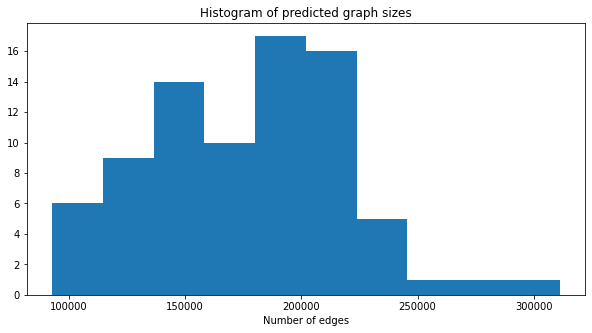

In [ ]:
plot_graph_sizes(metric_learning_model)

# 2. Construct graphs from metric learning inference

This step performs model inference on the entire input datasets (train, validation and test), to obtain input graphs to the graph neural network. Optionally, we also clear the directory.

In [ ]:
graph_builder = run_metric_learning_inference(CONFIG)

Loading BokehJS ...

Loading BokehJS ...

INFO:------------- Step 2: Constructing graphs from metric learning model -------------
INFO:---------------------------- a) Loading trained model ----------------------------
INFO:----------------------------- b) Running inferencing -----------------------------


Training finished, running inference to build graphs...


100%|██████████| 10/10 [00:01<00:00,  5.21it/s]


# 3. Train graph neural networks

We have a set of graphs constructed. We now train a GNN to classify edges as either "true" (belonging to the same track) or "false" (not belonging to the same track).

In [ ]:
gnn_trainer, gnn_model = train_gnn(CONFIG)

INFO:-------------------------  Step 3: Running GNN training  -------------------------
INFO:----------------------------- a) Initialising model -----------------------------
INFO:------------------------------ b) Running training ------------------------------
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 35.2 K
1 | edge_encoder           | Sequential | 66.4 K
2 | edge_network           | Sequential | 82.8 K
3 | node_network           | Sequential | 82.8 K
4 | output_edge_classifier | Sequential | 83.2 K
------------------------------------------------------
350 K     Trainable params
0         Non-trainable params
350 K     Total params
1.402     Total estimated model params size (MB)


Epoch 6:  36%|███▌      | 32/90 [00:10<00:19,  3.03it/s, loss=0.528, v_num=3]

## Plot training metrics

In [ ]:
gnn_metrics = get_training_metrics(gnn_trainer)
gnn_metrics.head()

Loading BokehJS ...

Loading BokehJS ...

epoch  train_loss  val_loss       eff       pur  current_lr
0      0    0.772983  0.782546  0.828301  0.606380      0.0002
1      1    0.726717  0.756100  0.840612  0.623862      0.0004
2      2    0.661249  0.689216  0.872466  0.649832      0.0006
3      3    0.597172  0.624752  0.863213  0.703532      0.0008
4      4    0.640994  0.552800  0.893797  0.728121      0.0010

In [ ]:
plot_training_metrics(gnn_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [ ]:
plot_edge_performance(gnn_model)

Loading BokehJS ...

Loading BokehJS ...

# Step 4: GNN inference 

In [ ]:
run_gnn_inference(CONFIG)

INFO:--------------------- Step 4: Scoring graph edges using GNN  ---------------------
INFO:---------------------------- a) Loading trained model ----------------------------
INFO:----------------------------- b) Running inferencing -----------------------------


Training finished, running inference to filter graphs...
Building train


100%|██████████| 80/80 [00:01<00:00, 78.56it/s]


Building val


100%|██████████| 10/10 [00:00<00:00, 21.31it/s]


Building test


100%|██████████| 10/10 [00:00<00:00, 24.97it/s]


# Step 5: Build track candidates from GNN

In [ ]:
build_track_candidates(CONFIG)

INFO:-----------  Step 5: Building track candidates from the scored graph  -----------
INFO:---------------------------- a) Loading scored graphs ----------------------------
INFO:---------------------------- b) Labelling graph nodes ----------------------------
100%|██████████| 129/129 [00:02<00:00, 46.90it/s]


# Step 6: Evaluate track candidates

We can control the matching style in the pipeline config file. The following all require at least a majority of hits to match in each scheme (i.e. matching fraction = 50%).
A discussion of each matching style and some worked examples can be found in the [Documentation](https://hsf-reco-and-software-triggers.github.io/Tracking-ML-Exa.TrkX/performance/matching_definitions/).

ATLAS style matching is the default.

INFO:------------ Step 6: Evaluating the track reconstruction performance ------------
INFO:--------------------------- a) Loading labelled graphs ---------------------------
100%|██████████| 100/100 [00:02<00:00, 43.54it/s]
INFO:--------------------- b) Calculating the performance metrics ---------------------
INFO:Number of reconstructed particles: 109213
INFO:Number of particles: 114164
INFO:Number of matched tracks: 137346
INFO:Number of tracks: 137881
INFO:Number of duplicate reconstructed particles: 28116
INFO:Efficiency: 0.957
INFO:Fake rate: 0.004
INFO:Duplication rate: 0.257
INFO:------------------------------ c) Plotting results ------------------------------


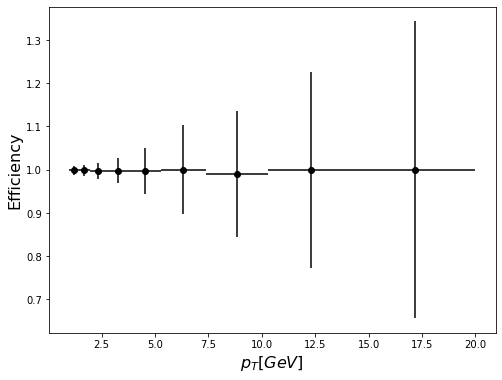

In [ ]:
evaluated_events, reconstructed_particles, particles, matched_tracks, tracks = evaluate_candidates(CONFIG)